In [1]:
import cv2
import numpy as np   
import matplotlib.pyplot as plt
from config import cal_anchors     

In [4]:
def draw_bboxes(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_


In [5]:
def flip(src,labels):
    w = src.shape[1]
    dst = cv2.flip(src,1)
    labels[:,1] = w-1-labels[:,1]
    return dst,labels
def pad_to_square(img):
        h,w,_= img.shape
        ts = max(h,w)
        diff1 = abs(h-ts)
        diff2 = abs(w-ts)
        pad = (diff1//2,diff2//2,diff1-diff1//2,diff2-diff2//2)
        img = cv2.copyMakeBorder(img,pad[0],pad[2],pad[1],pad[3],cv2.BORDER_CONSTANT,0)
        return img,(pad[0],pad[1])





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(2, 5)


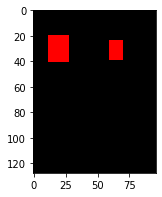

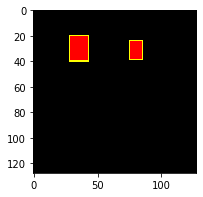

In [7]:
img = np.zeros([128,96,3])
labels = np.array([[0,20,30,15,20],[0,64,32,10,15]])
print(labels.shape)
img = draw_bboxes(img,labels[:,1:],(255,0,0),-1)
plt.figure(figsize=(3,3))
plt.imshow(img)
img_,pad = pad_to_square(img)
labels[:,1]+=pad[1]
labels[:,2]+=pad[0]
plt.figure(figsize=(3,3))
img_ = draw_bboxes(img_,labels[:,1:],(255,255,0),1)
plt.imshow(img_)




In [5]:
centers = {}
ious = []
for i in range(9,13):
    centers[i],km = cal_anchors(sizes=512,num=i)
    ious.append(km.cal_all_dist())
    print(i,centers[i])


TypeError: object of type 'int' has no len()

In [3]:
anchors,km = cal_anchors(sizes=512,num=9)
print(anchors)

(147793, 2)
27.184 19.732 17820
74.047 53.225 9373
20.775 39.826 14294
59.47 36.391 19204
35.381 32.168 34512
50.667 22.13 14614
39.331 46.979 26546
88.779 95.09 2337
44.967 72.927 9093
0.6185520671913861
0.7672917377344978 0.0009321494250144058
[[20.775, 19.732], [27.184, 22.13], [35.381, 32.168], [39.331, 36.391], [44.967, 39.826], [50.667, 46.979], [59.47, 53.225], [74.047, 72.927], [88.779, 95.09]]


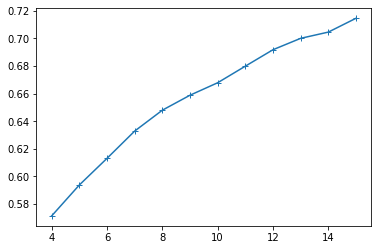

In [5]:
plt.plot(range(4,16),ious,'+-')

In [ ]:
#calculating clusters ratio and scale respectively 